In [1]:
%matplotlib inline

In [2]:
import diebold_Li_helpers as DL
reload(DL);
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
py.offline.init_notebook_mode()

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning:

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.




# Recreating Diebold and Li's Forecasting of Term Structure Yields
##  Michael Lee
## In Fullfillment of Time Series Econometrics, Spring 2016 


Diebold and Li's 2005 paper extends the work of Nelson-Siegel by forecasting the three exponential componenets used by Nelson and Siegel to fit the yield curve via autoregressive models. Diebold and Li are able to show that simple OLS models can be used to fit the Nelson-Siegel curve at each time period, and an autoregressive model of lag one can accurately forecast the fitted coefficients out of sample. This paper not only recreates and verifies Diebold and Li's work but also extends upon it by utilizing wavelet decomposition to seperate trends of varying time scales in forecasting. 

The Model is created using the python programming language, and is hosted interactively. 

Tags: _Nelson-Siegel, Diebold-Li, yield curves, wavelets_


!['Flowchart for the beta fits'](Assets/yieldlots.png)
<center>Yield Curves for Varying Maturities, 1980-2000</center>

## BACKGROUND
Term structure forecasting has many applications in both fixed-income portfolio management and risk management. The term structure a bond can be described the yield paid out for fixed maturity dates. Term structure modeling has traditionally been done from two mutually exclusive points of view: no-arbitrage and equilibrium modeling. Both of these traditions had different focuses and therefore different problems when applied to forecasting. Diebold and Li instead use the Nelson-Siegel exponential components framework to fit the term structure using three factors which can then be forecasting using autoregressive models. The advantage of this methodology will be demonstrated in this paper, but briefly are: the fitted components have economic interpretations, and allows for easy identification using traditional OLS methods. 

Diebold and Li apply autoregressive models (AR) to the fitted Nelson-Siegel parameters, and in effect forecast the yield curve itself. The resulting predictions are compared to standard benchmarks, and are shown to be considerably better in forecasting longer time horizon yields. 

I have extended Diebold and Li's AR(1) model by using wavelet decomposition to separate time and frequency-dependent volatility, which are then forecasted independently using and autoregressive integrated moving average (ARIMA) model. The use of such wavelet decomposition models allows for the cyclic components of varying frequencies to be fitted and forecasted _in vacuo_. 

The structure of this paper is as follows:
1. [Introduction to bond yields](#yields) 
2. [Fitting historical data via OLS](#OLS)
3. [Forecasting future term structures](#forecast)
4. [Extension with wavelets](#extension)
5. [Concluding remarks](#conclusion)


## <a name="yields"></a>THE NATURE OF YIELD CURVES
Let $P(\tau)$ denote the price of a $\tau-period$ discount bond, which is to say, the present value of a \$1.00 bond redeemable $\tau-periods$ in the future. If $y(\tau)$ is the continuously compounded yield to maturity (YTM), then the __discount curve__ can be defined as: 

\begin{equation}
    P(\tau) = e^{-\tau y(\tau)}
    \label{discount}
    \tag{eq: 1}
\end{equation}

The discount curve can be further related to the __forward rate__ curve, defined as:

\begin{equation}
    f(\tau) = \frac{-P'(\tau)}{P(\tau)}
    \label{forward}
    \tag{eq: 2}
\end{equation}

If we combine \ref{discount} and \ref{forward}, we can in turn relate the __yield curve__ (the curve in interest), with the forward rate curve (which is easily observed from bond prices). 

\begin{equation}
    y(\tau) = \frac{1}{\tau} \int_0^\tau f(u)du
    \label{yield}
    \tag{eq: 3}
\end{equation}



### <a name="NS"></a> Nelson-Siegel Yield Curves
One of the traditional difficulties in fitting yield curves has been the multitude of different forms they can take. Nelson and Siegel modeled the term structure using a three-component functional form which can be fitted using OLS regression. Where $\tau$ is the maturity date and $\lambda$ controls the exponential decay rate. 


$$\begin{equation}
    f_t(\tau) = \beta_1^t + \beta_2^t e^{-\lambda_t \tau} + \beta_3^t \lambda e^{-\lambda_t \tau}
    \tag{eq: 4}
\end{equation}$$

In Diebold and Li's paper, they factor the orignal Nelson-Seigel curve into a Laguerre function-- a polynomial times an exponential decay-- which have more intutive parameter interpretations. 

$$\begin{equation}
f_t(\tau) = \beta_1^t + \beta_2^t \left( \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} \right) + \beta_3^t \left(\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}\right)
\tag{eq: 5}
\label{NS}
\end{equation}$$

In Diebold and Li's interpreation, $\beta_1$, $\beta_2$, $ \beta_3$ correspond to three latent dynamic factors: the long-term factor, the short-term factor, and the medium-term factor. These factors can be further interpreted as the level, slope, and curvature of the yield curve. _Figure 1_ shows the factor loading curves as a function of maturity date.

<!---
Here is the figure of NS curve loadings
-->

<figure>
<center>
<img src="Assets/NS_factors.png" alt="Nelson-Siegel Parameters" style="width: 500px; height:400px"/>
<figcaption> Fig. 1: Nelson-Siegel Parameters</figcaption>
</center>
</figure>

_Figure 1_ is typical of the average yield curve. While it possible that yield curves can be convex and decreasing, i.e. 10 year rates are lower than the 3 month rates, the average yield curve is increasing and concave. The shape of the curve is in turn governed by the variations in $\beta_1$, $\beta_2$, and $\beta_3$. Stylistically, yield curves are more volatile in the short-term than the long-run. Long rates are also more persistent than short rates.

Diebold and Li also assign empirical interpretations to each loading. $\beta_1$ corresponds to the 10-year yield, and will effect all terms equally. $\beta_2$ is defined as the difference between the 10-year yield and the 3-month yield. $\beta_3$, the medium-term loading is interpreted as the difference between twice the 24 month  yield and the sum of 120 and 3 month yields.

Loading | Empirical Interpretation (months)         | Nelson-Siegel Fit            
---     | -------------------------------------------------- |----------------
$\beta_1$| $y_t(120)$                        | 1                 
$\beta_2$| $y_t(120) - y_t(3)$               | $\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau}$
$\beta_3$| $2y_t(24) -(y_t(120) + y_t(3))$   | $ \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}$

<center> Table 1: Nelson-Siegel Loadings</center>
## <a name="OLS"></a> FITTING THE NELSON-SIEGEL CURVE TO HISTORICAL YIELDS VIA OLS
Diebold and Li's model can be broadly viewed as a two-component model: first they fit historical data to the Nelson-Siegel parameters using OLS; secondly, they forecast the Nelson-Siegel parameters using an autoregressive model. This section will detail the use of OLS in fitting the term structure.

### Diebold and Li's Dataset
Diebold and Li use end-of-month price quotes for US treasuries taken from January 1985 to December 2000 taken from The Chicago Booth Center from Research in Security Prices (CRSP) government bond files. These prices are fitted such that bonds with options and those with maturity dates less than one month. The bonds are then converted into unsmoothed Fama-Bliss forward rates. Diebold and Li choose only bonds with fixed maturities, specifically those with maturity dates of 3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 48, 72, 96, 108, and 120 months. A contour plot of the dataset used can be seen (and explored!) below.

#### A Quick Aside on Fama-Bliss Yields
Recall that yield curves are not directly observable, but instead my be estimated via bond prices. Historically, this has been done following the vein of McColloch (1971, 1975) where the __discount curve__ is fitted using polynomial splines. However, fitting the yield curve via polynomial splines has issues, namely that the discount curve diverges at long maturities. Vasicek and Fong (1982) improved upon this discount curve fitting by using exponential splines, which ensures that the yields converge at long maturities, but necessitates that the forward rates must be positive. 

Fama and Bliss (1987) took an alternative approach, and instead fitted the yield curve by estimating __forward rates__. These rates are referred to as "unsmoothed Fama-Bliss" forward rates, which are then converted into unsmoothed Fama-Bliss yields via \ref{yield}





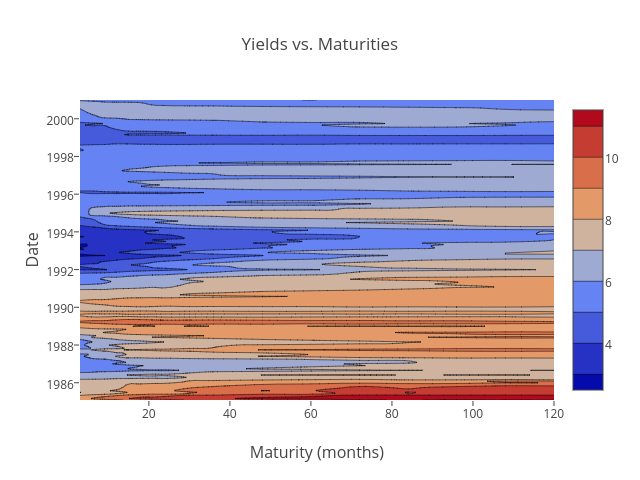

In [76]:
# load in Diebold and Li's dataset
# fit the model and return the fitted beta parameters 
# and their residuals
beta_fits, residuals, ratedata = DL.loadData()

yieldCurve = DL.yieldContors(ratedata)
py.plotly.image.ishow(yieldCurve)

# PRESS [SHIFT] + [ENTER] to execute this code block 

You can plot the yield curve for indivdual or a series of dates by adding them to the location variable below. Pick an index value between __[0, 191]__, or multiple dates by separating the values by commas. 

Ex: loc = [1, 5, 189]

Ex: loc = [55]


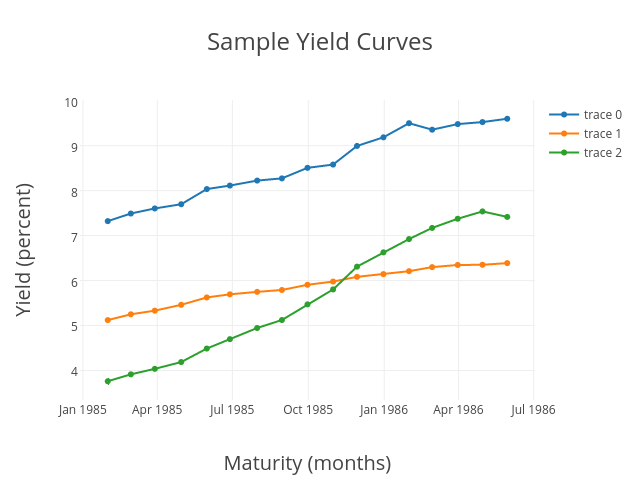

In [30]:
reload(DL)
loc = [10, 143, 88]
fig = DL.exampleYield(ratedata, loc)
py.plotly.image.ishow(fig)

### Fitting Yield Curves 
Each observed Fama-Bliss yield curve (monthly) must be fitted to the Nelson-Siegel curve. Recall however, that $\ref{NS}$ has the exponential decay term $\lambda$, which makes the estimation nonlinear. Diebold and Li avoid having to employ nonlinear least squares by instead fixing $\lambda=.0609$, the value that maximizes the loading on $\beta_2$, the medium-term factor, with the justification being that $\lambda$ sets the maturity at which the loading on $\beta_2$ achieves a maximum. In _Figure 2_ the algorithm for fitting the yield curves is detailed. 

<figure>
<center>
<img src="Assets/OLSflow.png" style="width: 800px; height:480px"/>
<figcaption>Flowchart for fitting in-sample yield curves</figcaption>
</center>
</figure>

Imagining a table (or dataframe) where each row is a different observation date, and each column the corresponding YTM _(1)_, we fit each row via OLS _(2)_ and save the three resulting $\beta$ parameters. More concretely:

`
i = 0 
for observation in dataset
    beta[i] = OLS.fit(observation, X)
    i += 1
end
 `
 
The result is a *[3 x N_observations]* table containing the OLS fits for each observation. Some summary statistics and goodness-of-fit tests are shown below.


//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



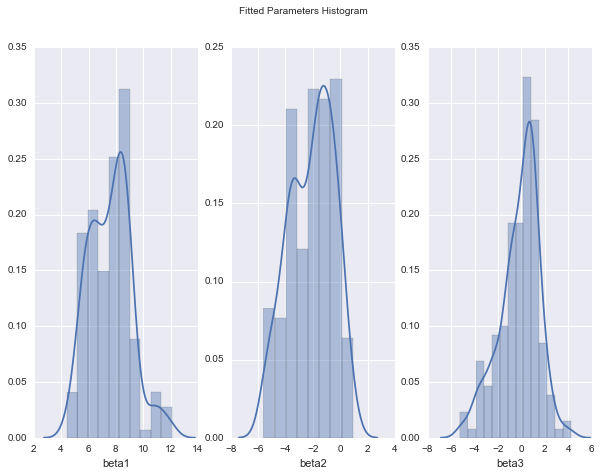

In [5]:
# Plot histograms for each of the fitted beta parameters
# non-interative
fig = DL.beta_dist(beta_fits)

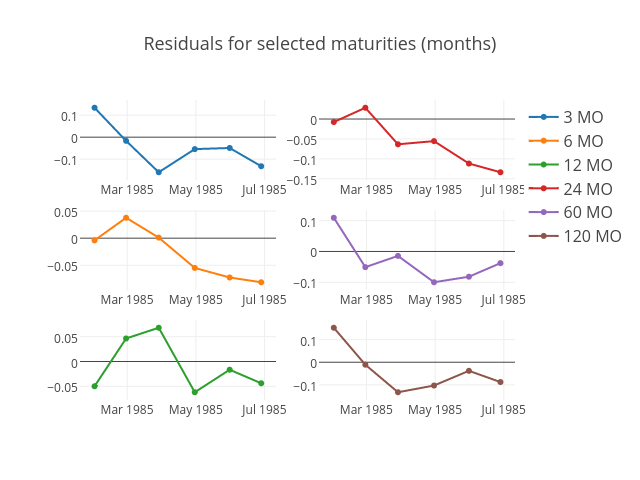

In [40]:
# Plot the residuals for some of the maturity dates
fig = DL.beta_resid(residuals)
py.plotly.image.ishow(fig)

#### Table 2
For comparison to Diebold and Li, I have included the same summary statistics of the OLS residuals that they provide in their paper (DL: Table 2). The correspondence is encouraging. Note that the high autocorrelation values for the term structure suggests that there are persistent discrepancies between the actual bond prices and what Nelson and Siegel predict. Diebold and Li suggest that these discrepancies could arise from tax and/or liquidity effects.


In [7]:
DL.table2(residuals)

,Mean,Std,Min,Max,MAE,RMSE,ACF(1),ACF(12),ACF(30)
3,-0.018284,0.080410,-0.331733,0.155740,0.060700,0.082258,0.777848,0.092878,-0.335279
6,-0.013473,0.041661,-0.141120,0.218058,0.031549,0.043682,0.290384,0.107583,-0.015771
9,-0.026008,0.061693,-0.200540,0.218223,0.051943,0.066803,0.704330,0.158475,-0.198754
12,0.013254,0.080082,-0.159594,0.266867,0.064369,0.080965,0.562485,0.229654,-0.246259
15,0.063149,0.049671,-0.062552,0.242228,0.067144,0.080263,0.649571,0.147223,-0.075218
18,0.047947,0.034878,-0.047638,0.165239,0.051662,0.059238,0.494133,0.088763,-0.018687
21,0.026009,0.029578,-0.091384,0.100584,0.033121,0.039329,0.368627,-0.049147,0.063735
24,-0.027371,0.044922,-0.190485,0.082034,0.037295,0.052504,0.666865,0.220948,0.067498
30,-0.017099,0.035609,-0.199743,0.098175,0.029053,0.039418,0.397610,0.038207,-0.088523
36,-0.037323,0.046060,-0.203361,0.127678,0.046674,0.059191,0.597620,0.001337,0.056748


### Plotting slope, level, and curvature
Below we plot the empirical level, slope, and curvature and compare them to their corresponding fitted $\beta$ parameters. The empirical interpretations can be found in _Table 1_. 


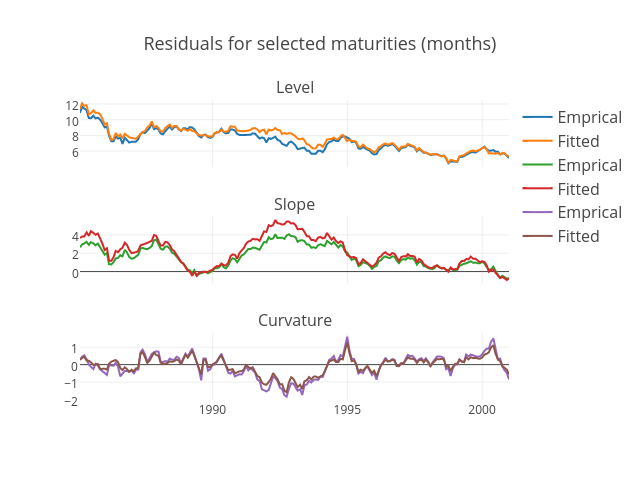

In [8]:
fig = DL.fig7(ratedata, beta_fits);
py.plotly.image.ishow(fig)

#### Table 3
For comparison to Diebold and Li, I have included the same descriptive statistics of the OLS beta fits that they provide in their paper (DL: Table 3). The data I present is identical to that of Diebold and Li, indicating that the model is replicated correctly. 

__NOTE:__ The augmented Dickey-Fuller (ADF) test for unit roots _strongly_ suggests that there are unit roots present in the $\beta_1$ and $\beta_2$ series. Diebold and Li briefly acknowledge this fact, but continue with their forecastings. Traditional wisdom suggests that AR forecasting can only be done with stationary data. In the interest of reproducing Diebold and Li's work, I will forecast these nonstationary series as well. 

In [9]:
DL.table3(beta_fits)

,Mean,Std,Min,Max,ACF(1),ACF(12),ACF(30),ADF
beta1,7.579812,1.523767,4.426683,12.088643,0.957332,0.482074,0.443502,-2.133352
beta2,-2.098801,1.607946,-5.615545,0.919011,0.969069,0.409026,-0.106957,-1.337617
beta3,-0.163536,1.685744,-5.250645,4.232782,0.901248,0.318661,-0.004457,-3.542007


## <a name="forecast"></a> FORECASTING INTO THE FUTURE
After fitting the observed yield curves to the Nelson-Siegel curves, we turn our attention towards forecasting the evolution of the parameters. Diebold and Li suggest using "the simplest great workhorse autoregressive models", to accomplish this task, and justify their selection over other, more sophisticated forecasting models. Specifically, Diebold and Li reject the use of a VAR model since there is little cross-variable interaction between parameters, and the truism that unrestricted VAR models tend to produce forecasts of economic variables. The authors instead choose to stack three independent AR(1) models. 

The AR(1) specification is as follows:

<center>
$$\begin{equation}
\hat{f}_{t+h}(\tau) = \hat{\beta}_1^{t+h} + \hat{\beta}_2^{t+h} \left( \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} \right) + \hat{\beta}_3^{t+h} \left(\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}\right)
\tag{eq: 6}
\label{AR}
\end{equation}$$
</center>
where, for $i=1,2,3$
<center>
\begin{equation}
\hat{\beta}_i^{t+h} = \hat{c}_i + \hat{\gamma}_i \hat{\beta}_i^{t}
\tag{eq: 7}
\end{equation}
</center>
The use of a single lag is justified by the autocorrelation (ACF) and partial autocorrelation (PACF) plots of the $\beta$ parameters. The exponential decay in the ACF after one lag is in line an autoregressive series of lag one. 
The PACF for all three $\beta$s is significant for only one period, also inline with expectations.


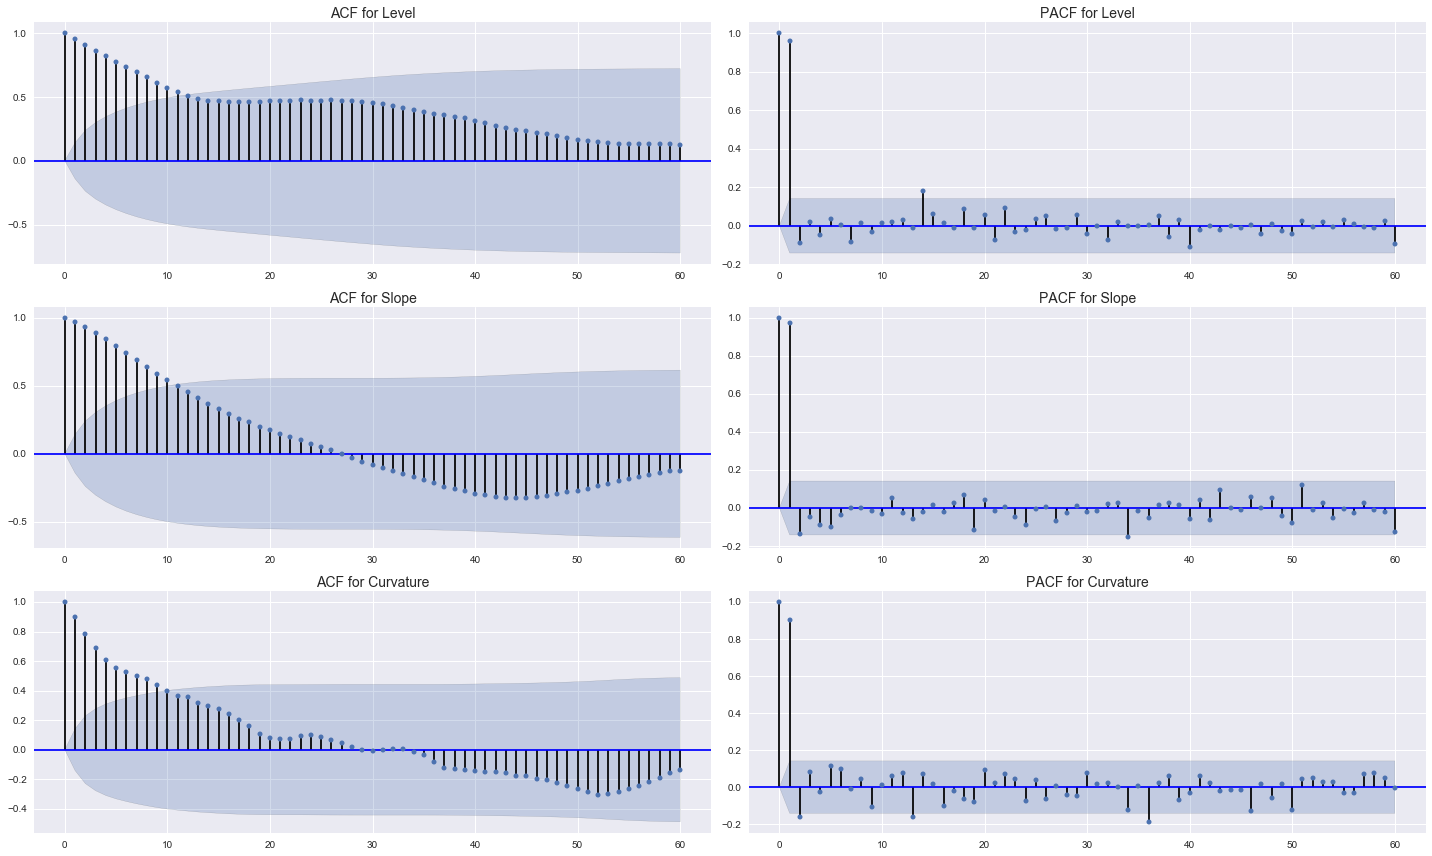

In [10]:
# plot the ACF for the betas and their residuals
DL.ACF_beta(beta_fits, residuals)

### Methodolgy
In order to test the fidelity of the AR(1) model we will withhold a sample of the original dataset (1985-1994) to train the model, and then use in-sample forecasting to validate our model on predicting 1994-2000. 

<figure>
<center> 
<img src=Assets/ARflow.png width=640; height=480/>
<figcaption>AR(1) Flowchart</figcaption>
</center>
</figure>

Since in [Part 2](#OLS) we showed that the Nelson-Siegel parameters sufficiently describe the yield curve, __forecasting the Nelson-Seigel parameters is equivielent to forecasting the yield curve!__ For each $\beta$s in the withheld sample, we will fit a univariate AR(1) model and forecast one month ahead. 

`
for observation in dataset[1994:2000]
    for beta in Betas
        model = ARfit(1985:observation-1, lags=1)
        prediction[observation, beta] = model.predict(date=observation)
`


In [97]:
# recursively forecast the beta parameters from Jan 1994->Dec 2000
naive_forecast, forecast, randomWalk, wavelets = DL.ARforecast(ratedata, beta_fits)

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done


#### Table 4
For comparison to Diebold and Li I have included a summary of 1-month ahead forecasting using the AR(1) model to recursively predict the Nelson-Siegel curves. 

Unlike in the previous tables, the results are not identical to those presented by Diebold and Li. Possible explanations can be to the software used to calculate the autoregression. I have used _statsmodels_-- a python package for time series analysis-- in fitting the AR parameters. The implementation in _statsmodels_ uses the conditional maximum likelihood using OLS MLE. As of the time of writing, I cannot confirm if Diebold and Li used exact MLE or conditional.


##### AR(1)

In [95]:
# plot table 4
DL.table4(naive_forecast, ratedata, False)

,mean,std. dev.,RMSE,ACF(1),ACF(12)
3,-0.070168,0.066939,0.096694,0.638823,0.026463
12,0.010944,0.078060,0.078351,0.497772,-0.012780
36,-0.054986,0.032114,0.063578,0.491333,-0.206814
60,-0.080756,0.060698,0.100801,0.802600,0.005742
120,-0.045005,0.070367,0.083166,0.675083,0.015775


##### Random walk

In [98]:
DL.table4(randomWalk, ratedata, False)

,mean,std. dev.,RMSE,ACF(1),ACF(12)
3,-0.036660,0.065291,0.074531,0.632377,-0.119513
12,0.032780,0.067271,0.074463,0.373529,0.096146
36,-0.036056,0.032486,0.048399,0.590199,-0.195701
60,-0.055335,0.036902,0.066386,0.611077,0.116992
120,-0.008296,0.070838,0.070892,0.677986,0.266585


##  <a name="extension"></a> EXTENDING DIEBOLD AND LI USING WAVELET DECOMPOSITION
By applying a univariate AR model, Diebold and Li implicitly ignore any seasonality in the dataset. While Diebold and Li were able to obtain good results on their limited dataset, this omission could prove problematic on higher frequency data which would be noisier. By separating out the trend and cyclic components, the, by definition deterministic, trend component can be forecasted independently from the stochastic shocks. Trend cycle decomposition has been covered before in the works of Beveridge and Nelson, unobserved components models, as well as using any number of bandpass filters. Filtering in particular suffers from the limitation that the periodicity of the data must be specified a priori, which add a layer of subjectivism to the fitting process. The efficacy of filtering also suffers if the intensity of the seasonal components is not constant throughout the series. The use of multiple resolution decomposition methods allays these limitations by decomposing the signal into an arbitrary number of __time-dependent frequency scales__, each of which can be recombined into recreate the original series. Each frequency range captures the evolution of trends at different scales, i.e. the long, short, and medium terms. 

Using wavelets to decompose the series should allow for each of the frequency scales to be forecasted independently and therefore increase the accuracy of our forecasts.

### A Brief Primer to Wavelet Theory 
The wavelet transform can be seen as a generalization of the Fourier transform that captures both the frequency content of the signal, but also the temporal fluctuations of the frequency spectrum. In the classic Fourier transform, no information is retained about _when_ specific spectral components occur. Let’s say, for example, the price of an asset was extremely volatile, but only for a short period of time. The periodgram created the the Fourier transform would smear this high frequency fluctuations across the entire time period. This could cause problems in forecasting, especially if this volatility was early on. 

Enter the continuous wavelet transform (CWT). The wavelet transform has two components, affection ally known as the mother and father wavelet. The mother wavelet ($\Psi$) characterizes the shape of the function and covers the entire domain of interest. The father wavelet ($\phi$) is the scaling function that is applied to the mother wavelet. By combining the mother and father wavelets (the result is known as a daughter wavelet), we can shift and scale the mother wavelet such that we completely capture the information in the original signal. 
<center>
\begin{equation}
    W_\Psi f(a,b) = \frac{1}{\sqrt{|a|}} \int^\infty_\infty \Psi(\frac{x-b}{a}) f(x)dx
    \label{wave}
    \tag{eq. 7}
\end{equation}
</center>
The inverse wavelet transform (ICWT) exists as well, and is used to reconstruct the original signal from the decomposed coefficients. 

Many "families" of wavelets exist, with each offering its own benefits tailored to specific shapes and characteristics of the signal you are trying to capture. For the Diebold and Li dataset, the Daubaechies 2 wavelet was chosen for its rapidly vanishing moment and sharp curvature. 
 

<!---
Here is the figure of NS curve loadings
-->

<figure>
<center>
<img src="Assets/db2wave.png" alt="Daubechies2" style="width: 550px; height:300px"/>
<figcaption> The Daubechies 2 Family</figcaption>
</center>
</figure>




__Note:__ Like its Fourier cousins, there are discrete and continuous wavelet transforms. The discrete version acts like a filter bank filled with high and low pass filters. The discrete transform is often faster, but since after each filtering round the filtered signal is downsampled, the resulting coefficients are not shift-invariant-- a trait we will need to forecast.

### Methodology
Following the lead of Diebold and Li, the variables of interest are the fitted Nelson-Siegel parameters, not the yield curves themselves. Thus, the basic algorithm described in [part 1](#OLS) and [part 2](#forecast) is followed: For each $\beta$

    1. Fit a selection of the data via OLS
    2. Use 1. to train an AR model 
    3. Predict h periods ahead

Wavelet decomposition will be applied between parts 1 and 2. Instead of fitting an AR model to the entirety $\beta$ time series, we will decompose each $\beta$ series into its constituent wavelet levels (each of which is a time series itself), and forecast each scale independently. The number of scales is determined by both the mother wavelet used, as well as the number of observations, with longer time series allowing for more levels. Thus, the forecasting algorithm can be seen as follows:

```
for observation in dataset[1994:2000]
    for beta in Betas
        waveC = cwt(dataset[1855:observation, beta])
        for level in waveC
            model = ARfit(waveC[level], lags=1)
            level.append(model.predict(date=observation))
        prediction[observation, beta] = icwt(level)
```


### Results and Remarks
The wavelet-aided AR(1) model preformed well, although not as well as the naive model did. However, I believe this is because the relatively small sample size used in Diebold and Li's dataset (only ~180 observations) the signal could only be decomposed at one level. Thus, we were able filter out the stochastic component, but only capture and forecast one frequency level.


#### The Wavelet Coherence Plot
Below is the wavelet coherence plot which shows the covariance between the mother wavelet and the fitted $\beta$ parameters at different scales and time periods. Regions of high (green) and low (purple) coherence indicate that the mother wavelet can accurately capture the features of the original signal. 

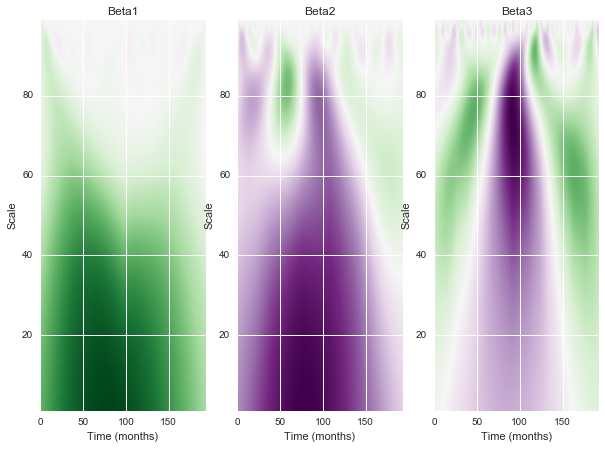

In [47]:
# plot the wavelet coherence plots
DL.cwtGraph(beta_fits)

#### Comparison of Average Forecasting Error
The wavelet-extended model is compared to the naive AR(1) model from [part 2](#forecasting) to see if it offers an improvement. The wavelet-extended model only out performs the naive model for the 5-year maturity date, and is significantly out performed for all other maturity periods. As mentioned before, this result is likely due to the small number of observations which prevented the wavelet decomposition from happening at multiple scales.



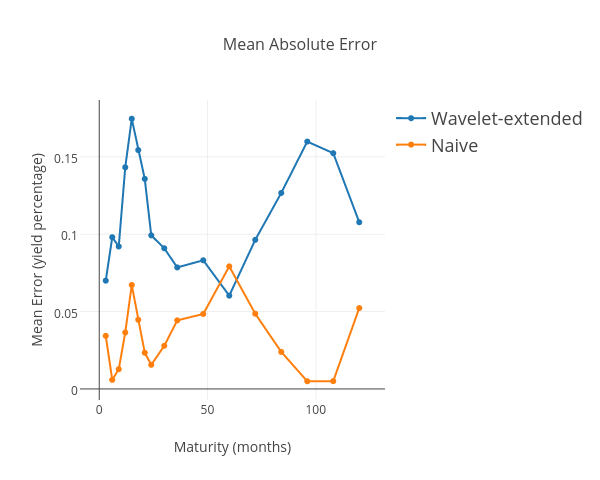

In [50]:
# plot the mean error
fig = DL.meanError(ratedata, naive_forecast, forecast)
py.plotly.image.ishow(fig)

#### Table 5
For comparison with the naive model, the same statistics shown in __Table 4__ are presented for the one month ahead wavelet assisted model

In [84]:
# plot table5
DL.table4(forecast, ratedata, False)

,mean,std. dev.,RMSE,ACF(1),ACF(12)
3,0.069995,0.162713,0.176216,0.630961,-0.199825
12,0.143247,0.199980,0.244998,0.590722,-0.290206
36,0.078531,0.235186,0.246586,0.565487,-0.235370
60,0.060290,0.224707,0.231328,0.522372,-0.168040
120,0.107742,0.202048,0.227890,0.468509,-0.104600


## <a name="conclusion"> </a> CONCLUDING REMARKS
Diebold and Li's 2005 paper on using autoregressive methods to forecast Nelson-Siegel parameters was recreated in using python. First, Fama-Bliss unsmoothed forward rates (1985-1994, monthly) were fitted at each observation to the Nelson-Siegel curve via OLS. The resulting series of Nelson-Siegel coefficients was then used to train an autoregressive model to predict future values of each parameter. The results obtained were consistent with those presented by Diebold and Li, with minor discrepancies in the predicted rates. 

The model was later extended by means of wavelet decomposition to forecast individual time-frequency resolutions for each beta. The extended model performed poorly compared to the naive model, however this is likely due to the limited number of observations in Diebold and Li's dataset.

Future work includes expanding the model to access daily bond data so the wavelet-extended model can decompose the series into higher order levels.



## REFERENCES 
Charles Nelson, A. S. (1987, Oct). Parismonious modeling of yield curves. The Journal of Business, 60(4), 473-489. Retrieved from jstor: http://www.jstor.org/stable/2352957?seq=1#page_scan_tab_contents

Francis Diebold, C. L. (2005, March 21). Forecasting the term structure of government bond yields. Journal of econometrics, 337-364.

Plotly. (2016). Plotly. Retrieved from Plot.ly: plot.ly

PyWavelets. (2016). Wavelet Daubechies 2. Retrieved from Wavelet Browser: http://wavelets.pybytes.com/wavelet/db2/

Renaud, O. (2002). Wavelet-based forecasting of short and long memory time series. University de Geneve. Geneve: University of Geneve.

Statsmodels. (2016). Statsmodels. Retrieved from Statsmodels: http://statsmodels.sourceforge.net

Tan, C. (2009). Fiancial time series forecasting using improved wavelet neural network. Master Thesis. 